# Tucker Decomposition
This decomposition aims to dins a core matrix and factor matrices that approximate to the given tensor:

$X \approx G \times U_s \times U_t \times U_p$, 

where:
- $G$: Core matrix.
- $U_s$: Factor matrix corresponding to the **TCR sequences** dimension.
- $U_t$: Factor matrix corresponding to the **time** dimension. 
- $U_p$: Factor matrix corresponding to the **patients** dimension. 


## Imports

### Import General Libraries

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl

# Ensure all rows and columns are displayed
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust width to prevent line breaks
pd.set_option('display.max_colwidth', None)  # Prevent truncation of cell content

### Import tensors
We don't need to convert to tensorly tensor as the numpy tensor already works (and give same results).

In [75]:
tensor_70 = np.load('tensors/tensor_70.npy')
tensor_100 = np.load('tensors/tensor_100.npy')
tensor_200 = np.load('tensors/tensor_200.npy')
tensor_300 = np.load('tensors/tensor_300.npy')

# tensor_200 = tl.tensor(tensor_200)

# we create a list with the tensors for more efficient coding
tensors = [tensor_70, tensor_100, tensor_200, tensor_300]
tensor_names = ['70', '100', '200', '300']

In [76]:
# Log transform - try log transform to see if results change

# Apply log transform to each tensor
log_transformed_tensors = [np.log1p(tensor) for tensor in tensors]  # log(1 + x) to avoid log(0) issues
tensors = log_transformed_tensors

## Choose ranks
We run SVD in each dim to find the suitable number of ranks for the decomposition. We try several thresholds and we plot the results to find the elbow (and the appropriate number of ranks). These ranks are shared among the different applications of Tucker decomposition.

In [77]:
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
from scipy.linalg import svd
from kneed import KneeLocator  # For automatic elbow detection

# Function to compute reconstruction error
def error(original, res):
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)


def compute_svd_ranks(tensor, tensor_name, threshold=0.75, error_threshold=0.05, method="variance", plot_s=False):
    """
    Computes the optimal rank for each mode using SVD, selecting ranks based on 
    either variance retention or reconstruction error. Plots all three modes in 
    a single figure for better visualization.

    Parameters:
    tensor (np.array): The input tensor
    tensor_name (str): The name of the tensor (for labeling plots)
    threshold (float): The percentage of variance to retain when choosing ranks (used for variance method)
    error_threshold (float): The acceptable reconstruction error threshold (used for reconstruction error method)
    method (str): Selection method - "variance" or "reconstruction_error"

    Returns:
    ranks_selected (list): Selected ranks for each mode
    """
    ranks_selected = []
    thres_rank = []

    # Create a single figure with 3 subplots (one for each mode)
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    fig.suptitle(f"{'Cumulative Variance' if method == 'variance' else 'Reconstruction Error'} for tensor_{tensor_name}", fontsize=14)

    if plot_s == True:
        # Create a single figure with 3 subplots (one for each mode)
        fig2, axes2 = plt.subplots(1, 3, figsize=(17, 5))
        fig2.suptitle("Singular values", fontsize=14)

    for mode in range(tl.ndim(tensor)):
        # Matricize tensor along the mode
        matricized = tl.unfold(tensor, mode)
        
        # print(f'Original shape: {tensor.shape}')
        # print(f'Matricized shape: {matricized.shape}')
        U, S, Vt = svd(matricized, full_matrices=False)
        # print(S)
        # print(S.shape)
        # plt.figure()
        # plt.bar(np.arange(1, len(S) + 1),S)
        # plt.xlabel('singular value position')
        # plt.ylabel('singular value')
        # plt.title(f'Mode {mode}')

        if plot_s == True:
            axes2[mode].bar(np.arange(1, len(S) + 1),S)
            axes2[mode].set_xlabel('Singular value position')
            axes2[mode].set_ylabel('Singular value')
            axes2[mode].set_title(f'Mode {mode}')

        if method == "variance":
            # Compute cumulative explained variance
            cumulative_variance = np.cumsum(S**2) / np.sum(S**2)

            # Select rank based on variance threshold
            selected_rank = np.searchsorted(cumulative_variance, threshold) + 1
            thres_rank.append(selected_rank)

            # Elbow Method: Automatically detect the best rank
            elbow_locator = KneeLocator(np.arange(1, len(S) + 1), cumulative_variance, curve="concave", direction="increasing")
            selected_rank_elbow = elbow_locator.knee if elbow_locator.knee else selected_rank
            

            # Plot variance retention
            ax = axes[mode]
            ax.plot(np.arange(1, len(S) + 1), cumulative_variance, marker='o', linestyle='-', label='Cumulative Variance')
            if selected_rank_elbow:
                ax.axvline(x=selected_rank_elbow, color='r', linestyle='--', label='Elbow')
                ax.axvline(x=selected_rank, color='k', linestyle='--', label=f'Threshold ({threshold})')

            ax.set_ylabel("Cumulative Explained Variance")
            # print(f'Mode {mode}')
            # print(f'    Var rank: {selected_rank}, Elbow rank: {selected_rank_elbow}')

        elif method == "reconstruction_error":
            # Compute reconstruction errors
            ranks = np.arange(1, len(S) + 1)
            errors = np.zeros_like(ranks, dtype=float)

            for i, r in enumerate(ranks):
                reconstructed = (U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :])
                errors[i] = error(matricized, reconstructed)

            # Detect elbow point
            elbow_locator = KneeLocator(ranks, errors, curve="convex", direction="decreasing")
            selected_rank_elbow = elbow_locator.knee or ranks[-1]

            # Plot
            ax = axes[mode]
            ax.plot(ranks, errors, color='g', marker='o', linestyle='-', label=f"Error ({error_threshold})")
            ax.axvline(selected_rank_elbow, color='r', linestyle='--', label="Elbow")

            ax.set_ylabel("Reconstruction Error")
            # ax.set_yscale("log")  # Log scale for better visualization

        else:
            raise ValueError("Invalid method. Choose 'variance' or 'reconstruction_error'.")

        # Append the selected rank for this mode
        ranks_selected.append(selected_rank_elbow)
    

        # Labels & Titles
        ax.set_xlabel("Number of Ranks")
        ax.set_title(f"Mode {mode}")
        ax.grid()

    # Show a shared legend only once
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.show()
    
    if method == 'reconstruction_error':
        return ranks_selected
    elif method == 'variance':
        return ranks_selected, thres_rank


Rank selection for tensor_70


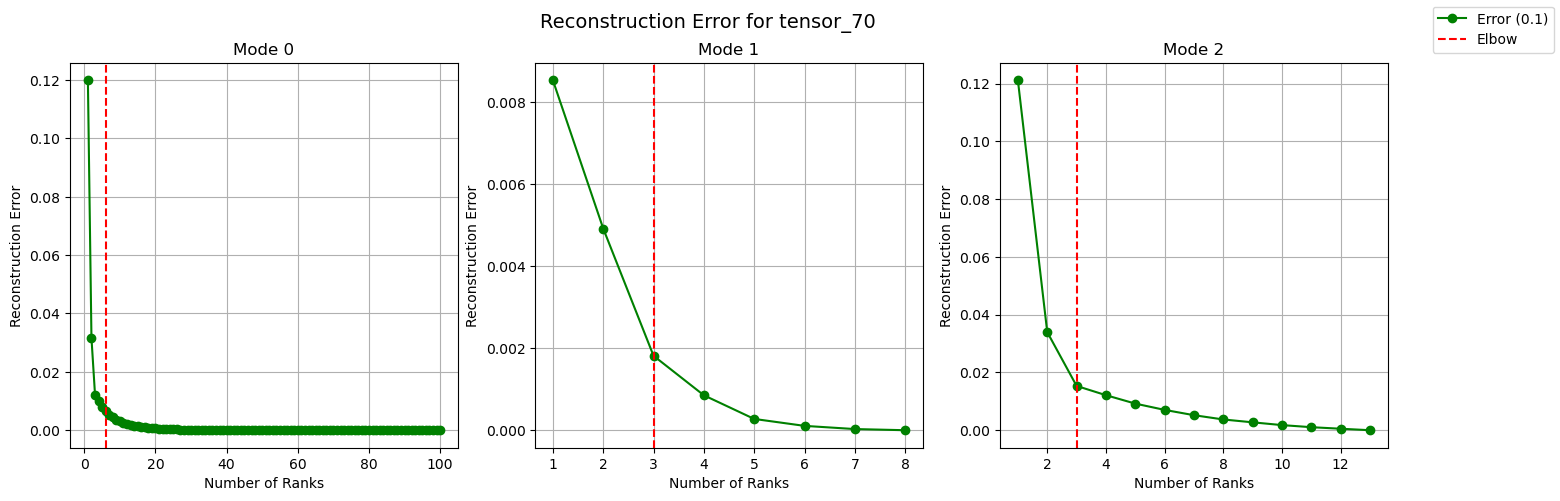

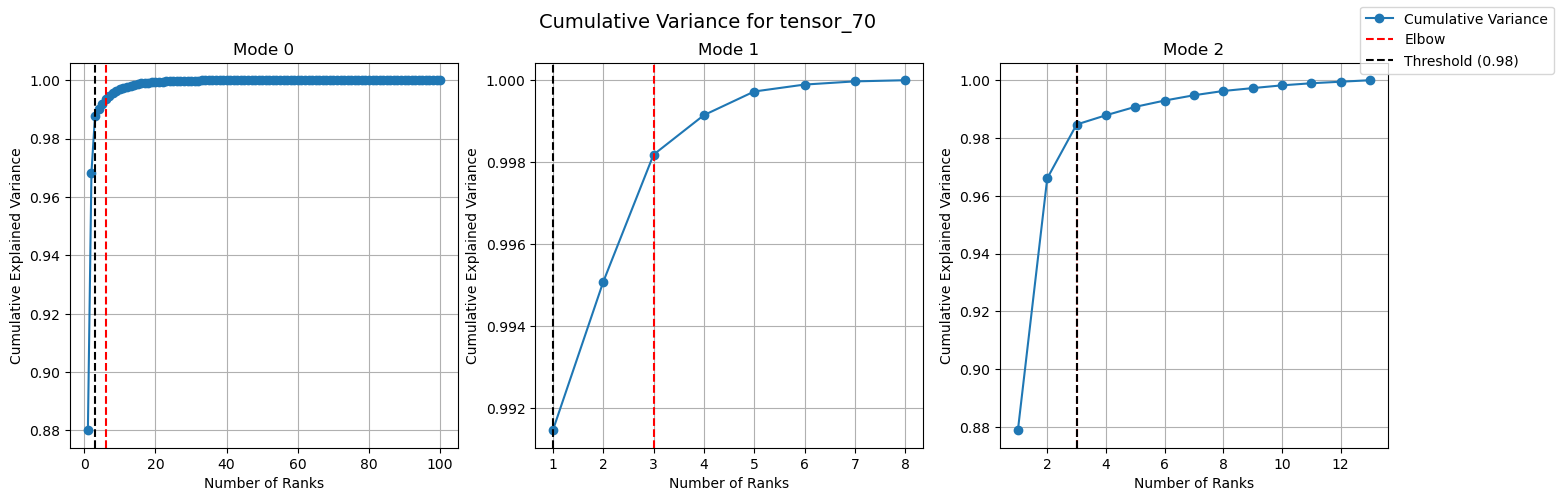

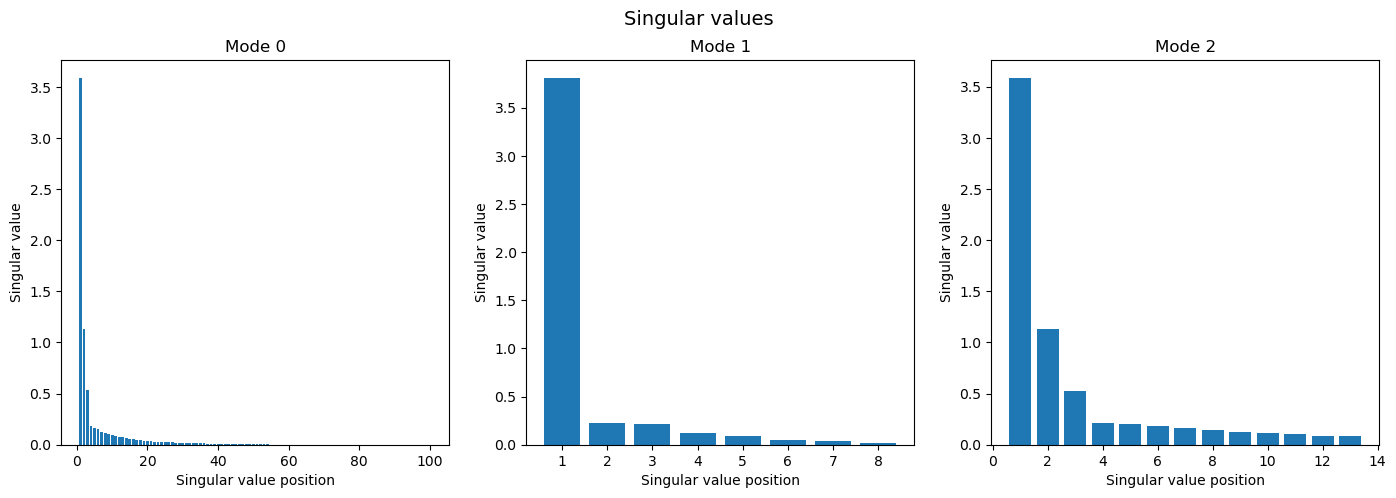

Rank selection for tensor_100


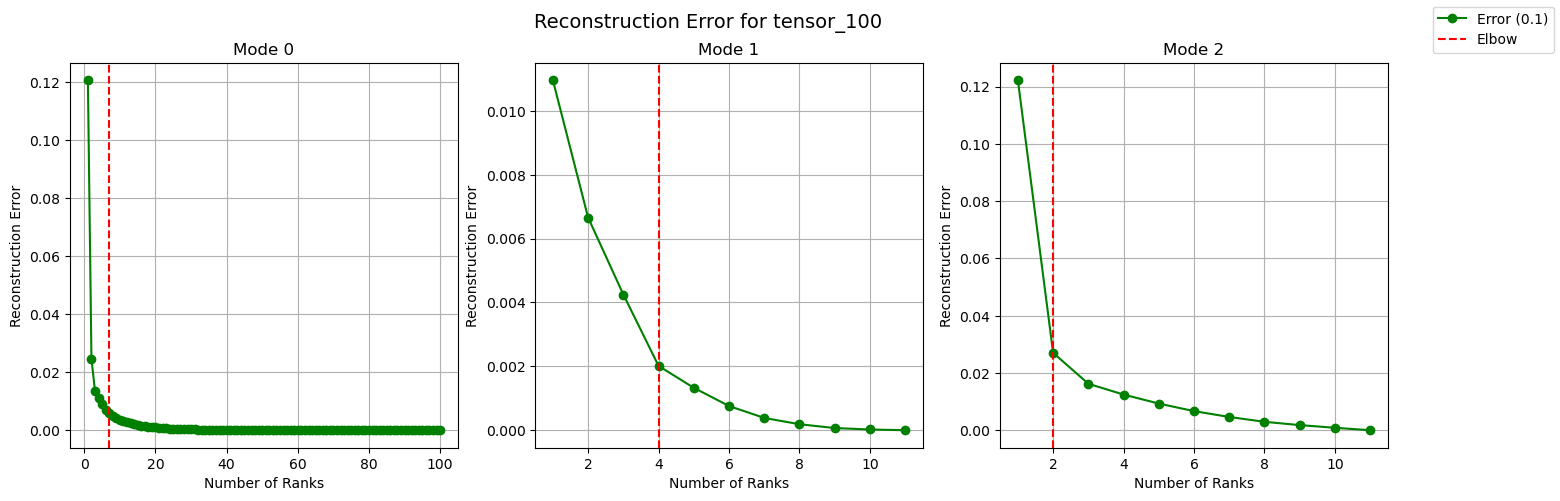

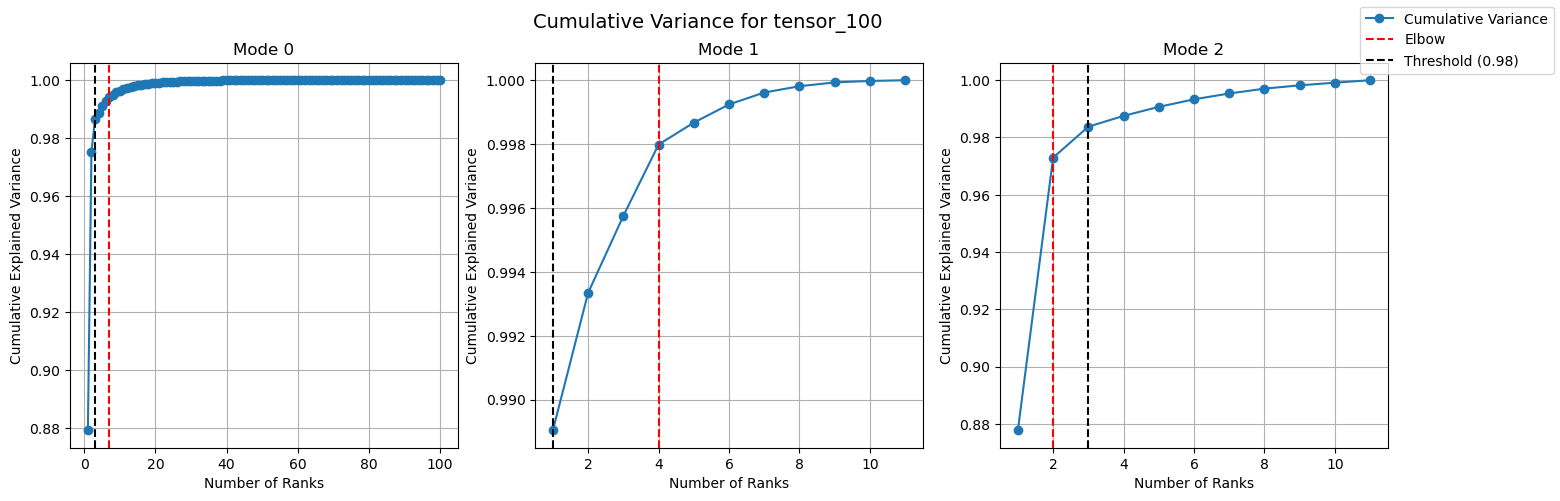

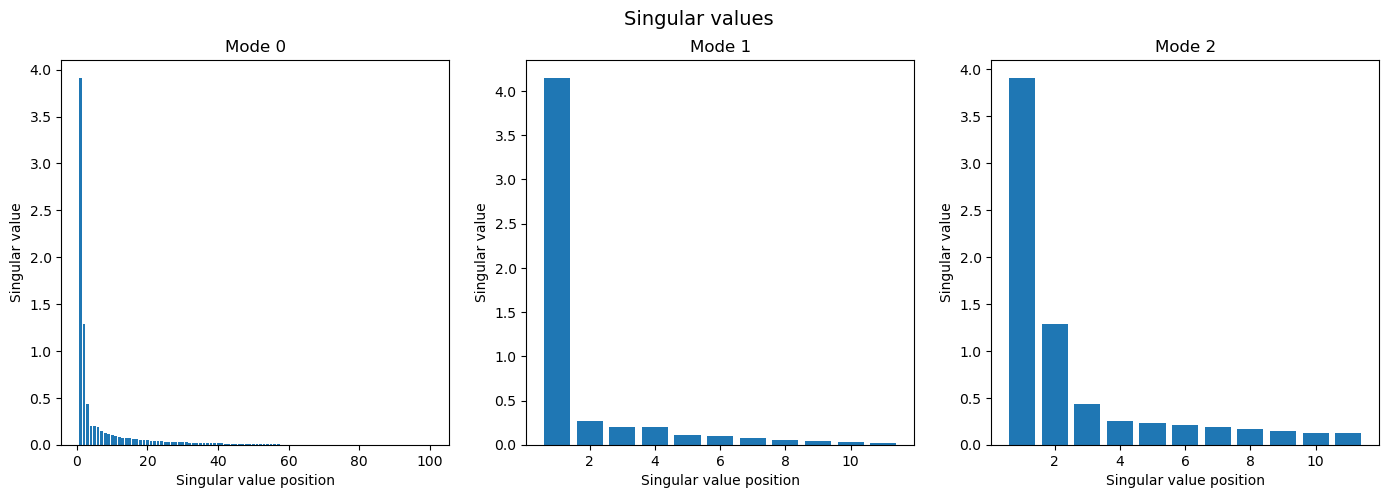

Rank selection for tensor_200


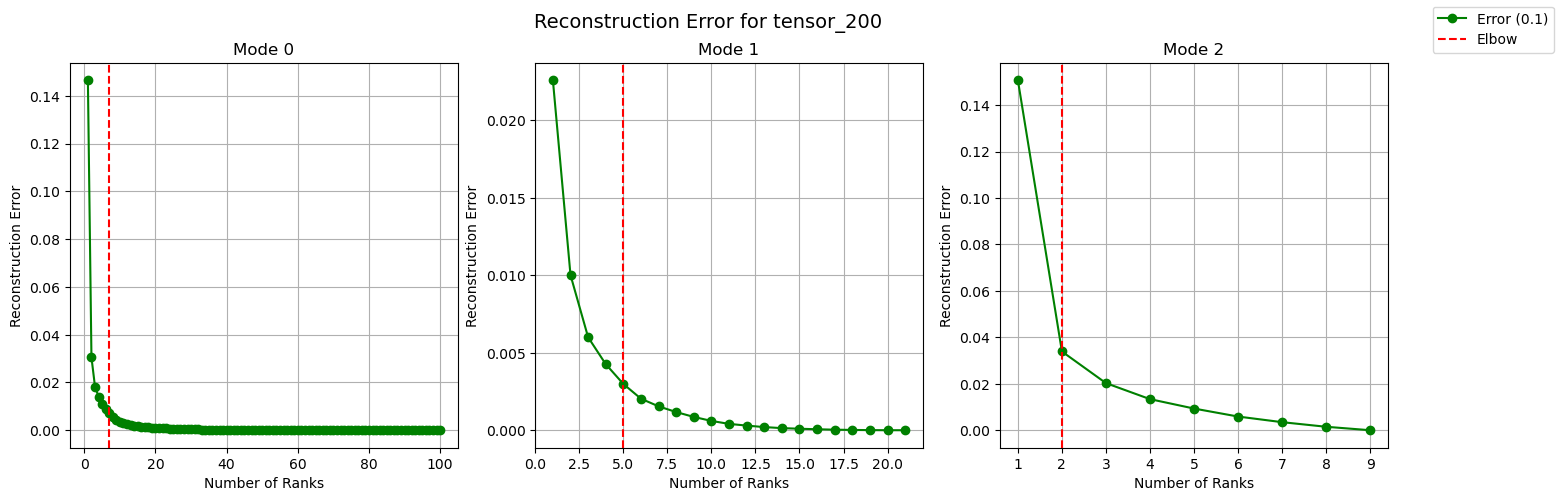

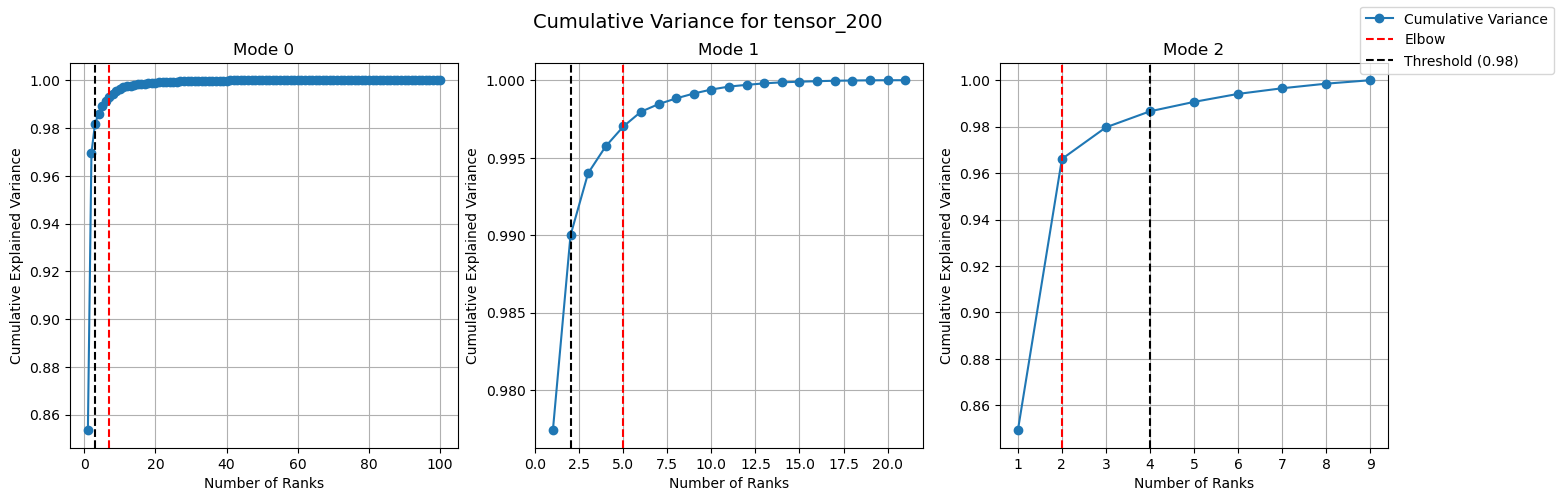

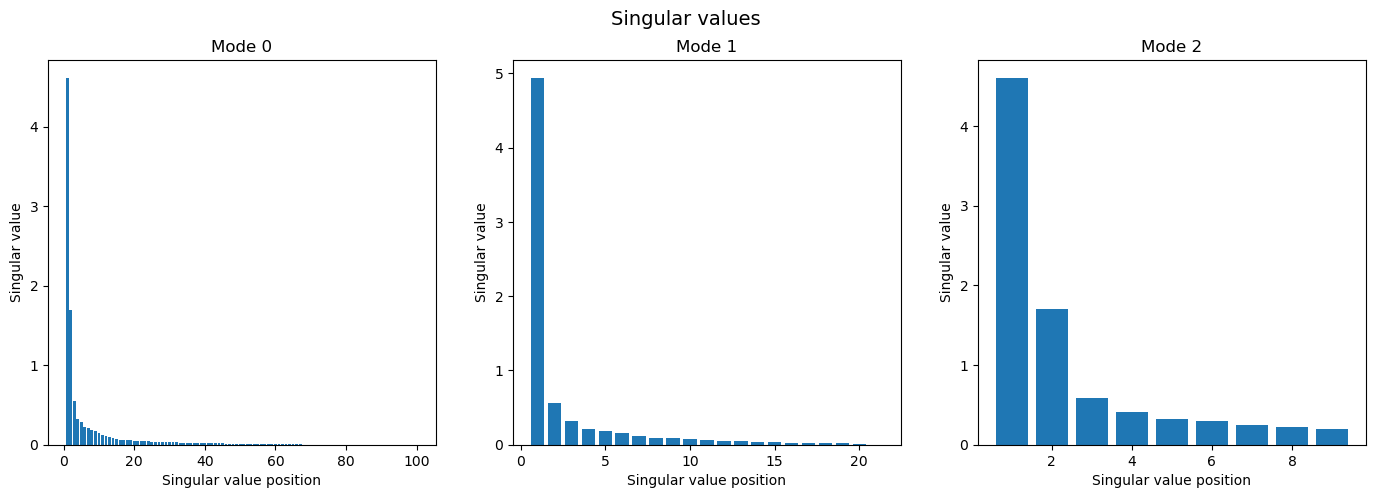

Rank selection for tensor_300


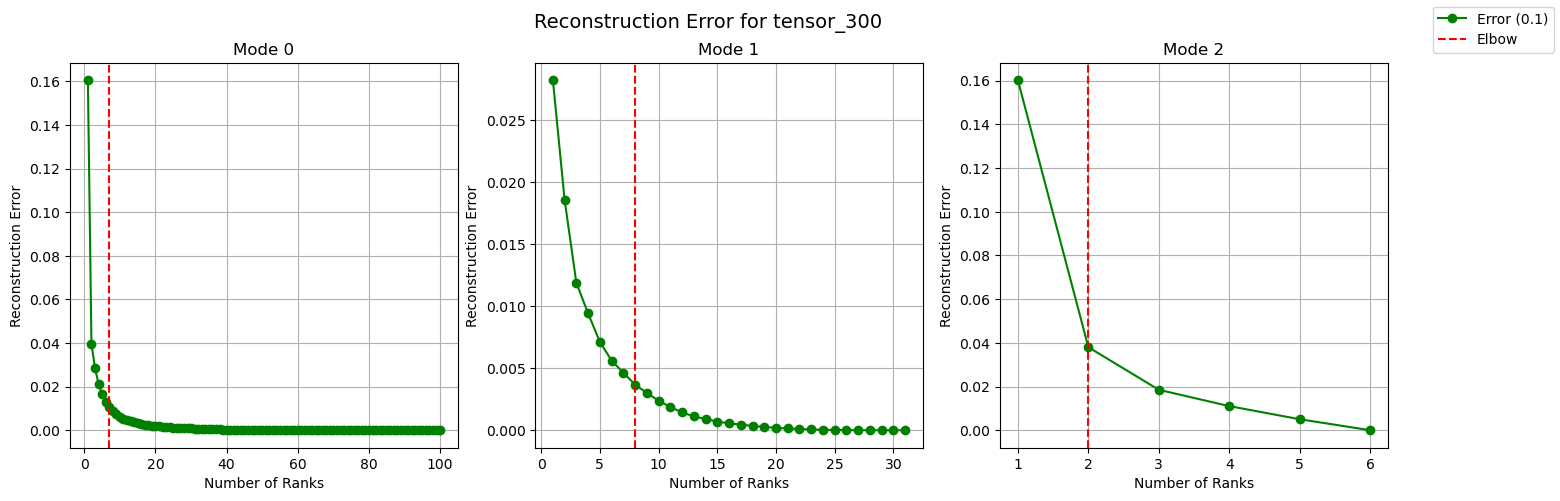

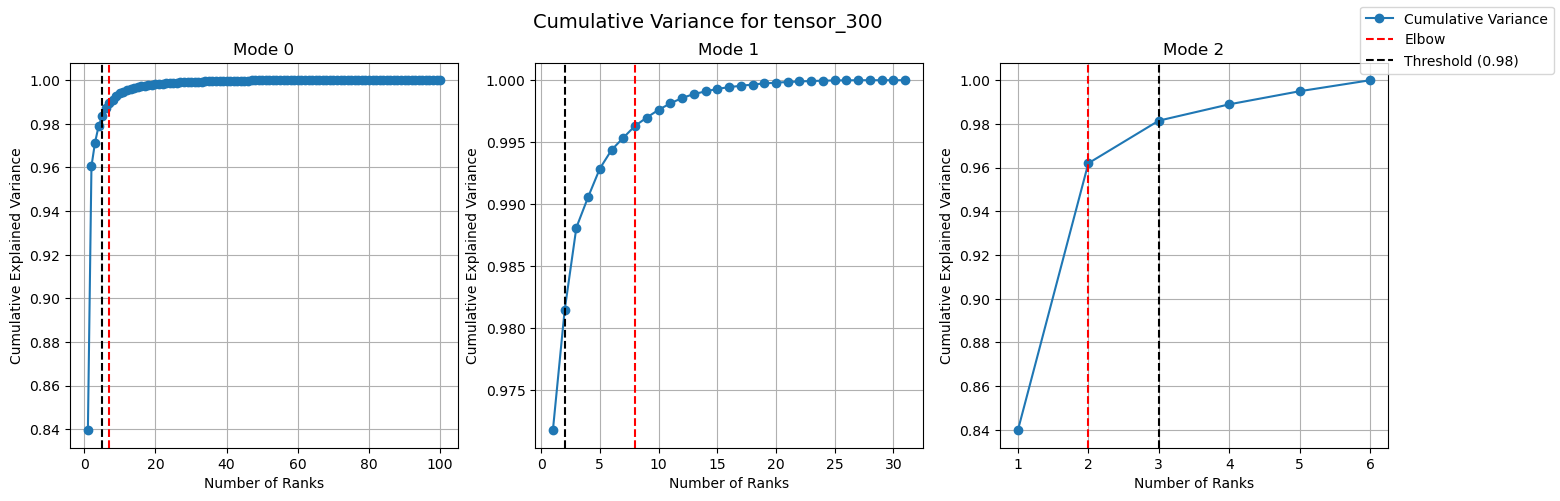

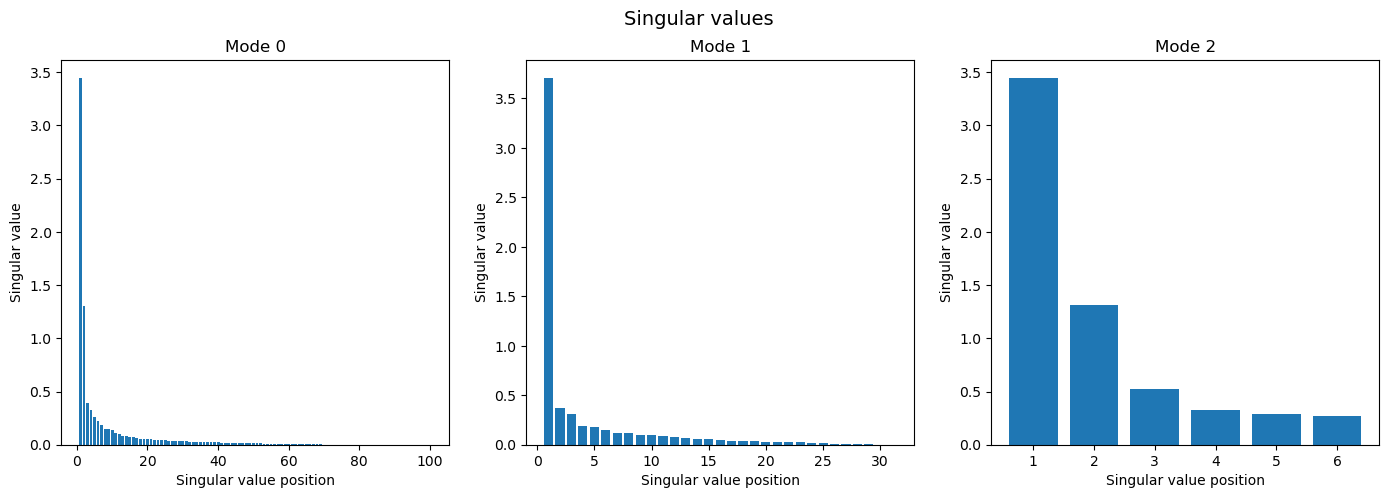


FINAL RANKS (Explained Variance - threshold=0.98):
    Final Ranks for tensor_70: elbow --> [6, 3, 3], threshold --> [3, 1, 3]
    Final Ranks for tensor_100: elbow --> [7, 4, 2], threshold --> [3, 1, 3]
    Final Ranks for tensor_200: elbow --> [7, 5, 2], threshold --> [3, 2, 4]
    Final Ranks for tensor_300: elbow --> [7, 8, 2], threshold --> [5, 2, 3]

FINAL RANKS (Reconstruction Error - threshold=0.1):
    Final Ranks for tensor_70: [6, 3, 3]
    Final Ranks for tensor_100: [7, 4, 2]
    Final Ranks for tensor_200: [7, 5, 2]
    Final Ranks for tensor_300: [7, 8, 2]


In [91]:
# Run for all our tensors using Variance Method
final_ranks_variance = []  
final_ranks_thresh = []
final_ranks_reconstruction = []  

threshold = 0.98  # Variance retention threshold
error_threshold = 0.1  # Acceptable reconstruction error threshold

for i, tensor in enumerate(tensors):
    tensor_name = tensor_names[i]  # To label the tensor (e.g., time 70, 100, 200, 300)
    print(f'Rank selection for tensor_{tensor_name}')

    # Compute ranks using Reconstruction Error-based selection
    selected_ranks_reconstruction = compute_svd_ranks(tensor, tensor_name, threshold=threshold, error_threshold=error_threshold, method="reconstruction_error")
    final_ranks_reconstruction.append(selected_ranks_reconstruction)

    # Compute ranks using Variance-based selection
    selected_ranks_variance, thres_ranks = compute_svd_ranks(tensor, tensor_name, threshold=threshold, error_threshold=error_threshold, method="variance", plot_s=True)
    final_ranks_variance.append(selected_ranks_variance)
    final_ranks_thresh.append(thres_ranks)

    

# Print final ranks for Variance method
print(f'\nFINAL RANKS (Explained Variance - threshold={threshold}):')
for i, tensor in enumerate(tensors):
    print(f"    Final Ranks for tensor_{tensor_names[i]}: elbow --> {final_ranks_variance[i]}, threshold --> {final_ranks_thresh[i]}")

# Print final ranks for Reconstruction Error method
print(f'\nFINAL RANKS (Reconstruction Error - threshold={error_threshold}):')
for i, tensor in enumerate(tensors):
    print(f"    Final Ranks for tensor_{tensor_names[i]}: {final_ranks_reconstruction[i]}")


## Decompositions
Three different analysis can be done with Tucker: exploratory analysis (to find hidden patterns), clustering (to find groupings), and classification (to classify new data).

### Exploratory analysis
We start with exploratory analysis to find hidden patterns. To have better interpretability, we use HALS-NTS algorithm to ensure that the non-negativity constraint is applied and hence, yield to more interpretable results (as they have biological meaning). Also, thi salgorithm refines the result iteratively.


#### Decomposition

In [ ]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_tucker_hals  # HALS-NTD
from tensorly.decomposition import non_negative_tucker

# Dictionary to store results
tucker_results = {}
final_ranks = final_ranks_thresh # DECIDE BASED ON PREVIOUS RESULTS
# final_ranks = final_ranks_reconstruction
# final_ranks = final_ranks_variance

# TEST - SET MODE 1 (TIME) TO 3 RANKS
# print(final_ranks_thresh)
# final_ranks = final_ranks_thresh
# final_ranks = [[a, 3, c] for a, b, c in final_ranks]
# print(final_ranks)


# print(final_ranks)

# Loop over all tensors and apply HALS-NTD Tucker decomposition
for i, tensor in enumerate(tensors):
    tensor_name = tensor_names[i]
    ranks = tuple(final_ranks[i])  # Ensure ranks are a tuple

    print(f"\nProcessing {tensor_name}: Tensor shape {tensor.shape}, Ranks {ranks}")

    try:
        # Convert tensor to TensorLy tensor
        tensor = tl.tensor(tensor)

        # Apply HALS-NTD Tucker decomposition
        core, factors = non_negative_tucker_hals(tensor, rank=ranks, n_iter_max=100, tol=1e-6)
        # core, factors = non_negative_tucker(tensor, rank=ranks)

        # Store results
        tucker_results[tensor_name] = {
            "core_tensor": core,
            "factor_matrices": factors
        }

        print(f"    tensor_{tensor_name} decomp shapes:")
        print(f"        core: {core.shape}")
        print(f"        Us: {factors[0].shape}")
        print(f"        Ut {factors[1].shape}")
        print(f"        Up {factors[2].shape}")
    except ValueError as e:
        print(f"Error in decomposition for {tensor_name}: {e}")



Processing 70: Tensor shape (100, 8, 13), Ranks (6, 3, 3)
    tensor_70 decomp shapes:
        core: (6, 3, 3)
        Us: (100, 6)
        Ut (8, 3)
        Up (13, 3)

Processing 100: Tensor shape (100, 11, 11), Ranks (7, 4, 2)
    tensor_100 decomp shapes:
        core: (7, 4, 2)
        Us: (100, 7)
        Ut (11, 4)
        Up (11, 2)

Processing 200: Tensor shape (100, 21, 9), Ranks (7, 5, 2)
    tensor_200 decomp shapes:
        core: (7, 5, 2)
        Us: (100, 7)
        Ut (21, 5)
        Up (9, 2)

Processing 300: Tensor shape (100, 31, 6), Ranks (7, 8, 2)
    tensor_300 decomp shapes:
        core: (7, 8, 2)
        Us: (100, 7)
        Ut (31, 8)
        Up (6, 2)


#### Visualization
We can visualise 4 different plots, one for each core and factor matrices from the decomposition. 
- `factors[0]` $ = U_s$: Factor matrix corresponding to the **TCR sequences** dimension. Can be visualised using heatmaps.
- `factors[1]` $ = U_t$: Factor matrix corresponding to the **time** dimension. Can be visualised using timeseries.
- `factors[2]` $ = U_p$: Factor matrix corresponding to the **patients** dimension. Can be visualised using clustering techniques.
- `core` $ = G$: Core matrix. Can be visualised using slice-wise heatmaps.

In [80]:
def plot_factor_matrix_heatmap(factor_matrix, column_labels=None, row_labels=None, y_label=None, x_label=None, title="Factor Matrix Heatmap"):
    plt.figure(figsize=(12, 6))

    ax = sns.heatmap(factor_matrix, cmap="RdPu", cbar=True, linewidths=0.5)

    # Label rows and columns
    if column_labels:
        ax.set_xticks(np.arange(len(column_labels)) + 0.5)
        ax.set_xticklabels(column_labels, rotation=90)
    else:
        ax.set_xticks([])

    if row_labels:
        ax.set_yticks(np.arange(len(row_labels)) + 0.5)
        ax.set_yticklabels(row_labels,rotation=45)
    else:
        ax.set_yticks([])

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


In [81]:
def plot_factor_matrix_timeseries(factor_matrix, y_label=None, x_label='Time (Days)', title="Factor Matrix Timeseries", step=10):
    """
    Plots the factor matrix as multiple time series, one per rank.

    Parameters:
    - factor_matrix (np.array): The factor matrix (time x ranks).
    - y_label (str): Label for y-axis (optional).
    - x_label (str): Label for x-axis.
    - title (str): Title of the plot.
    - step (int): Step size for x-axis ticks (default is 10).
    """
    # Find number of ranks
    ranks = factor_matrix.shape[1]    
    fig, ax = plt.subplots(ranks, 1, figsize=(12, 3*ranks), sharex=True)  # Share x-axis for better alignment

    # Define correct x-axis values (time steps)
    time_steps = np.arange(0, factor_matrix.shape[0] * step, step)  

    if ranks == 1:
        plt.plot(time_steps, factor_matrix[:, ranks-1])  # Plot using time_steps
        plt.ylabel(f'Rank {ranks}')

        # Set x-ticks at correct intervals
        plt.xticks(time_steps, labels =time_steps)
        # plt.xtickslabels(time_steps)  # Ensure labels match tick positions

        # Set labels and title
        plt.xlabel(x_label)
    else:
        for i in range(ranks):
            ax[i].plot(time_steps, factor_matrix[:, i])  # Plot using time_steps
            ax[i].set_ylabel(f'Rank {i+1}')

        # Set x-ticks at correct intervals
        ax[-1].set_xticks(time_steps)
        ax[-1].set_xticklabels(time_steps)  # Ensure labels match tick positions

        # Set labels and title
        ax[-1].set_xlabel(x_label)
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [82]:
# def plot_core_tensor_slices(core_tensor, slice_axis=0, title="Core Tensor Slices"):
#     """
#     Plots slice-wise heatmaps of the core tensor along a specified axis.

#     Parameters:
#     - core_tensor (np.array): The core tensor from Tucker decomposition.
#     - slice_axis (int): The axis along which to slice (0, 1, or 2).
#     - title (str): Title of the figure.
#     """
#     num_slices = core_tensor.shape[slice_axis]  # Number of slices along the chosen axis

#     fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
#     fig.suptitle(title, fontsize=14)

#     # Iterate over slices along the specified axis
#     for i in range(num_slices):
#         if slice_axis == 0:
#             slice_data = core_tensor[i, :, :]  # Fix first dimension, vary last two
#             slice_title = f"Slice {i+1} (Mode 0)"
#         elif slice_axis == 1:
#             slice_data = core_tensor[:, i, :]  # Fix second dimension
#             slice_title = f"Slice {i+1} (Mode 1)"
#         else:
#             slice_data = core_tensor[:, :, i]  # Fix third dimension
#             slice_title = f"Slice {i+1} (Mode 2)"

#         ax = axes[i] if num_slices > 1 else axes
#         sns.heatmap(slice_data, cmap="jet", cbar=True, ax=ax)
#         ax.set_title(slice_title)

#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()


In [83]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_core_tensor_slices(core_tensor, slice_axis=2, title="Core Tensor Slices"):
#     """
#     Plots slice-wise heatmaps of the core tensor along a specified axis.

#     Parameters:
#     - core_tensor (np.array): The core tensor from Tucker decomposition.
#     - slice_axis (int): The axis along which to slice (0, 1, or 2).
#     - title (str): Title of the figure.
#     """

#     if multi_slice == True:
#         num_slices = core_tensor.shape[slice_axis]  # Number of slices along the chosen axis
#         fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
#         fig.suptitle(title, fontsize=14)

#         # Iterate over slices along the specified axis
#         for i in range(num_slices):
#             if slice_axis == 0:
#                 slice_data = core_tensor[i, :, :]  # Fix first dimension, vary last two
#                 slice_title = f"Slice {i+1} (Mode 0)"
#             elif slice_axis == 1:
#                 slice_data = core_tensor[:, i, :]  # Fix second dimension
#                 slice_title = f"Slice {i+1} (Mode 1)"
#             else:
#                 slice_data = core_tensor[:, :, i]  # Fix third dimension
#                 slice_title = f"Slice {i+1} (Mode 2)"

#             ax = axes[i] if num_slices > 1 else axes
#             sns.heatmap(slice_data, cmap="RdPu", cbar=True, ax=ax)

#             # Generate correct rank labels based on slice size
#             rank_labels_x = [f"Rank {j+1}" for j in range(slice_data.shape[1])]
#             rank_labels_y = [f"Rank {j+1}" for j in range(slice_data.shape[0])]

#             # Ensure tick positions match the labels
#             ax.set_xticks(np.arange(len(rank_labels_x)) + 0.5)
#             ax.set_yticks(np.arange(len(rank_labels_y)) + 0.5)

#             # Set tick labels ensuring they match the axis dimensions
#             ax.set_xticklabels(rank_labels_x, rotation=0, ha="right")
#             ax.set_yticklabels(rank_labels_y, rotation=0)

#             ax.set_title(slice_title)

#         plt.tight_layout(rect=[0, 0, 1, 0.96])
#         plt.show()


In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_core_tensor_slices(core_tensor, slice_axis=2, multi_slice=False, title="Core Tensor Slices"):
    """
    Plots slice-wise heatmaps of the core tensor.
    
    Parameters:
    - core_tensor (np.array): The core tensor from Tucker decomposition.
    - slice_axis (int): The axis along which to slice (0, 1, or 2).
    - multi_slice (bool): If True, slices along all three axes; if False, only along `slice_axis`.
    - title (str): Title of the figure.
    """
    
    def plot_slices(core_tensor, slice_axis, fig_title):
        """Helper function to plot slices along a given axis"""
        num_slices = core_tensor.shape[slice_axis]
        fig, axes = plt.subplots(1, num_slices, figsize=(5 * num_slices, 5))
        fig.suptitle(fig_title, fontsize=14)

        for i in range(num_slices):
            if slice_axis == 0:
                slice_data = core_tensor[i, :, :]  # Fix first dimension
                slice_title = f"Slice {i+1} (Mode-0)"
            elif slice_axis == 1:
                slice_data = core_tensor[:, i, :]  # Fix second dimension
                slice_title = f"Slice {i+1} (Mode-1)"
            else:
                slice_data = core_tensor[:, :, i]  # Fix third dimension
                slice_title = f"Slice {i+1} (Mode-2)"

            ax = axes[i] if num_slices > 1 else axes
            sns.heatmap(slice_data, cmap="RdPu", cbar=True, ax=ax)

            # Generate rank labels
            rank_labels_x = [f"Rank {j+1}" for j in range(slice_data.shape[1])]
            rank_labels_y = [f"Rank {j+1}" for j in range(slice_data.shape[0])]

            # Set tick labels
            ax.set_xticks(np.arange(len(rank_labels_x)) + 0.5)
            ax.set_yticks(np.arange(len(rank_labels_y)) + 0.5)
            ax.set_xticklabels(rank_labels_x, rotation=0, ha="right")
            ax.set_yticklabels(rank_labels_y, rotation=0)
            ax.set_title(slice_title)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # **Multi-Slice Mode: Plot slices along all 3 axes in separate figures**
    if multi_slice:
        for axis in range(3):
            if slice_axis==0:
                mode='Horizontal'
            elif slice_axis==1:
                mode='Vertical'
            else:
                mode='Frontal'
            plot_slices(core_tensor, slice_axis=axis, fig_title=f"{title} - {mode} (Mode-{slice_axis}) Slices")

    # **Single-Slice Mode: Only plot slices along the specified `slice_axis`**
    else:
        if slice_axis==0:
            mode='Horizontal'
        elif slice_axis==1:
            mode='Vertical'
        else:
            mode='Frontal'
        plot_slices(core_tensor, slice_axis=slice_axis, fig_title=f"{title} - {mode} (Mode-{slice_axis}) Slices")


In [85]:
# Core matrix - find most relevant
from itertools import product
def most_relevant(core_tensor):
    # Convert core tensor to a DataFrame with meaningful statistics
    core_tensor_df = pd.DataFrame({
        "Index": list(product(*[np.arange(1, si+1) for si in core_tensor.shape])),  # Tuple index
        "Weight": core_tensor.flatten(),  # Raw core tensor values
        "Fraction": core_tensor.flatten()**2,  # Energy contribution
        # "Sign": np.sign(core_tensor.flatten())  # Positive or negative value
    })

    # Normalize Fraction to sum to 1 (percentage of importance)
    core_tensor_df["Fraction"] /= core_tensor_df["Fraction"].sum()

    # Convert index tuples to string for better visualization
    core_tensor_df["Index"] = core_tensor_df["Index"].astype(str)

    # Sort by Fraction (importance) in descending order
    core_tensor_df = core_tensor_df.sort_values("Fraction", ascending=False)

    return core_tensor_df 

In [86]:
def decomp_visualizations(td_dic,t_name,pat_list):
    core = td_dic['core_tensor']
    factors = td_dic['factor_matrices']
    Us = factors[0]  
    Ut = factors[1]
    Up = factors[2]
    # Us - 1 figure
    column_labels = [f"Rank {i+1}" for i in range(Us.shape[1])]
    row_labels = [f"{i+1}" for i in range(Us.shape[0])]
    y_label = 'Sequences'
    plot_factor_matrix_heatmap(Us, column_labels=column_labels, y_label=y_label,title=f"Us Heatmap for tensor_{t_name}")

    # Ut - 1 figure: 1 rank 1 subplot or all ranks 1 subplot
    plot_factor_matrix_timeseries(Ut,title=f"Ut Timeseries for tensor_{t_name}")

    # Up - 1 figure
    y_label = 'Patients'
    column_labels = [f"Rank {i+1}" for i in range(Up.shape[1])]
    row_labels = [f"{pat_list[i]}" for i in range(Up.shape[0])]
    plot_factor_matrix_heatmap(Up, column_labels=column_labels,row_labels=row_labels, y_label=y_label,title=f"Up Heatmap for tensor_{t_name}")

    # Core matrix - 1 figure, each slice is 1 subplot
    # plot_core_tensor_slices(core, slice_axis=0, title=f"Core tensor Heatmaps by slice for tensor_{t_name}")
    # plot_core_tensor_slices(core, slice_axis=1, title=f"Core tensor Heatmaps by slice for tensor_{t_name}")
    plot_core_tensor_slices(core, slice_axis=2, title=f"Core tensor Heatmaps by slice for tensor_{t_name}")
    core_tensor_df = most_relevant(core)
    print(core_tensor_df)

##### tensor_70

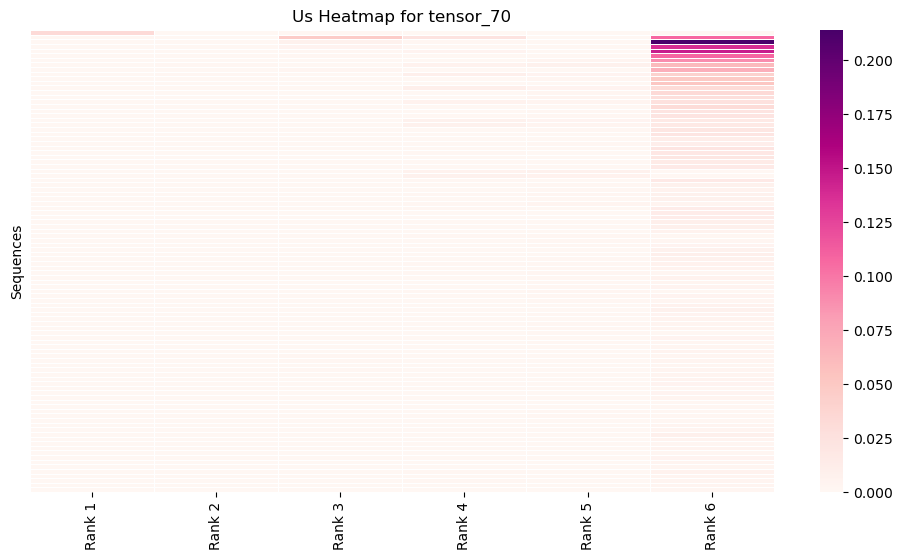

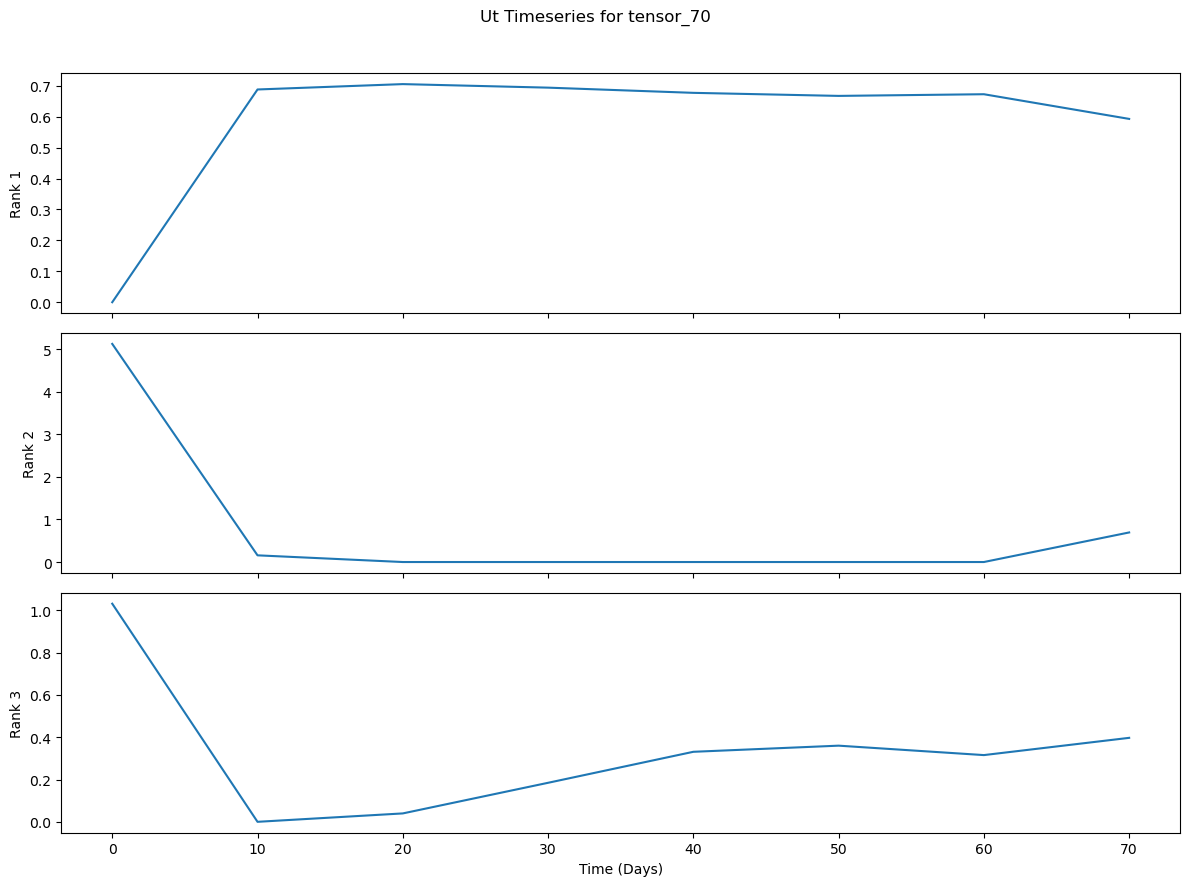

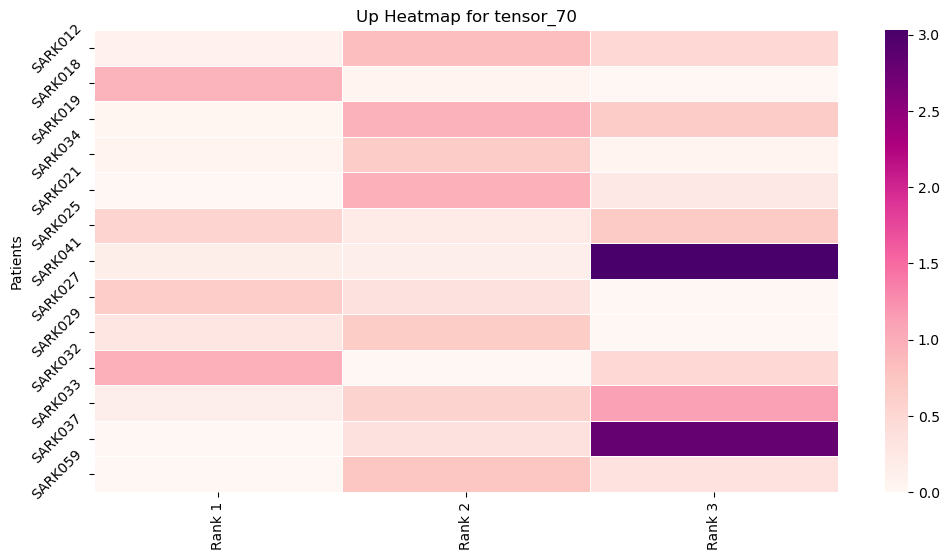

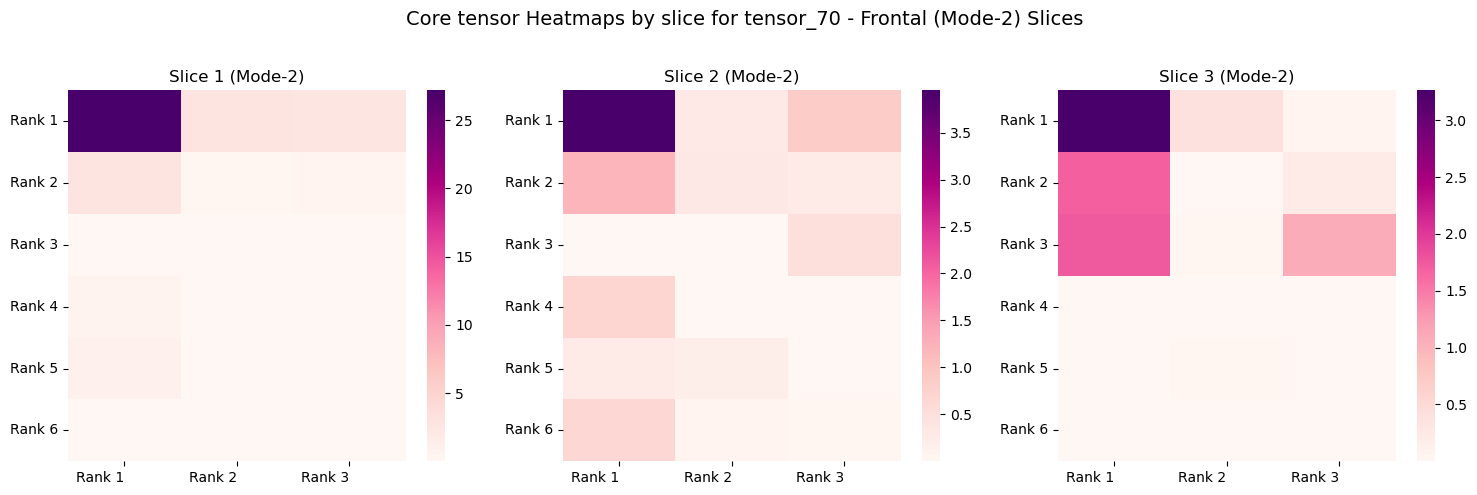

        Index        Weight      Fraction
0   (1, 1, 1)  2.717339e+01  9.216936e-01
1   (1, 1, 2)  3.950504e+00  1.948068e-02
2   (1, 1, 3)  3.262637e+00  1.328730e-02
9   (2, 1, 1)  2.933030e+00  1.073821e-02
3   (1, 2, 1)  2.774417e+00  9.608213e-03
6   (1, 3, 1)  2.720309e+00  9.237100e-03
20  (3, 1, 3)  1.757577e+00  3.855916e-03
11  (2, 1, 3)  1.696039e+00  3.590631e-03
10  (2, 1, 2)  1.200658e+00  1.799441e-03
26  (3, 3, 3)  1.091829e+00  1.488019e-03
36  (5, 1, 1)  9.429628e-01  1.109911e-03
7   (1, 3, 2)  8.523865e-01  9.069266e-04
28  (4, 1, 2)  7.005126e-01  6.125351e-04
46  (6, 1, 2)  6.738202e-01  5.667442e-04
27  (4, 1, 1)  6.521409e-01  5.308624e-04
25  (3, 3, 2)  5.208345e-01  3.386090e-04
15  (2, 3, 1)  4.275766e-01  2.282059e-04
5   (1, 2, 3)  3.910490e-01  1.908804e-04
12  (2, 2, 1)  3.716056e-01  1.723707e-04
13  (2, 2, 2)  3.366827e-01  1.414948e-04
4   (1, 2, 2)  2.968911e-01  1.100255e-04
16  (2, 3, 2)  2.605546e-01  8.474155e-05
37  (5, 1, 2)  2.473112e-01  7.634

In [87]:
i=0 #tensor_70
td_dic = tucker_results[tensor_names[i]]
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']
decomp_visualizations(td_dic,tensor_names[i], pat_list=pat_list)

##### tensor_100

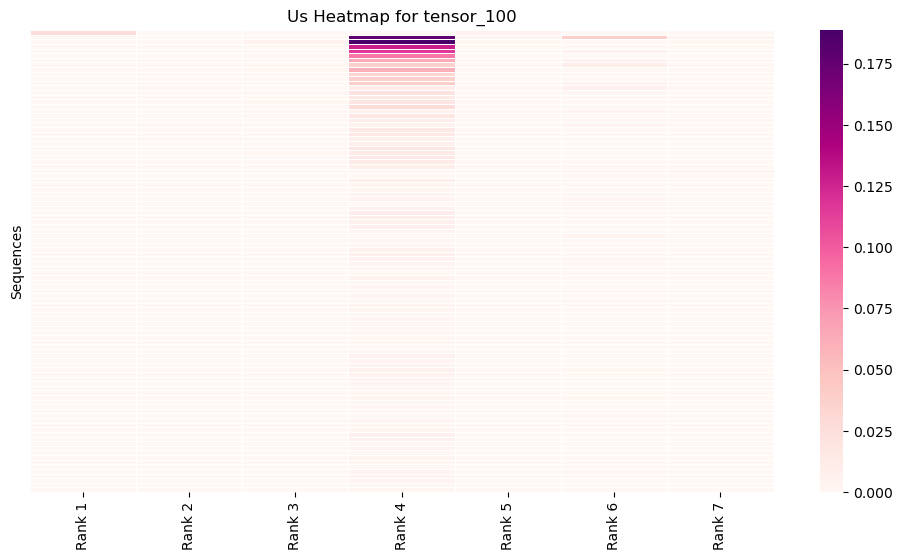

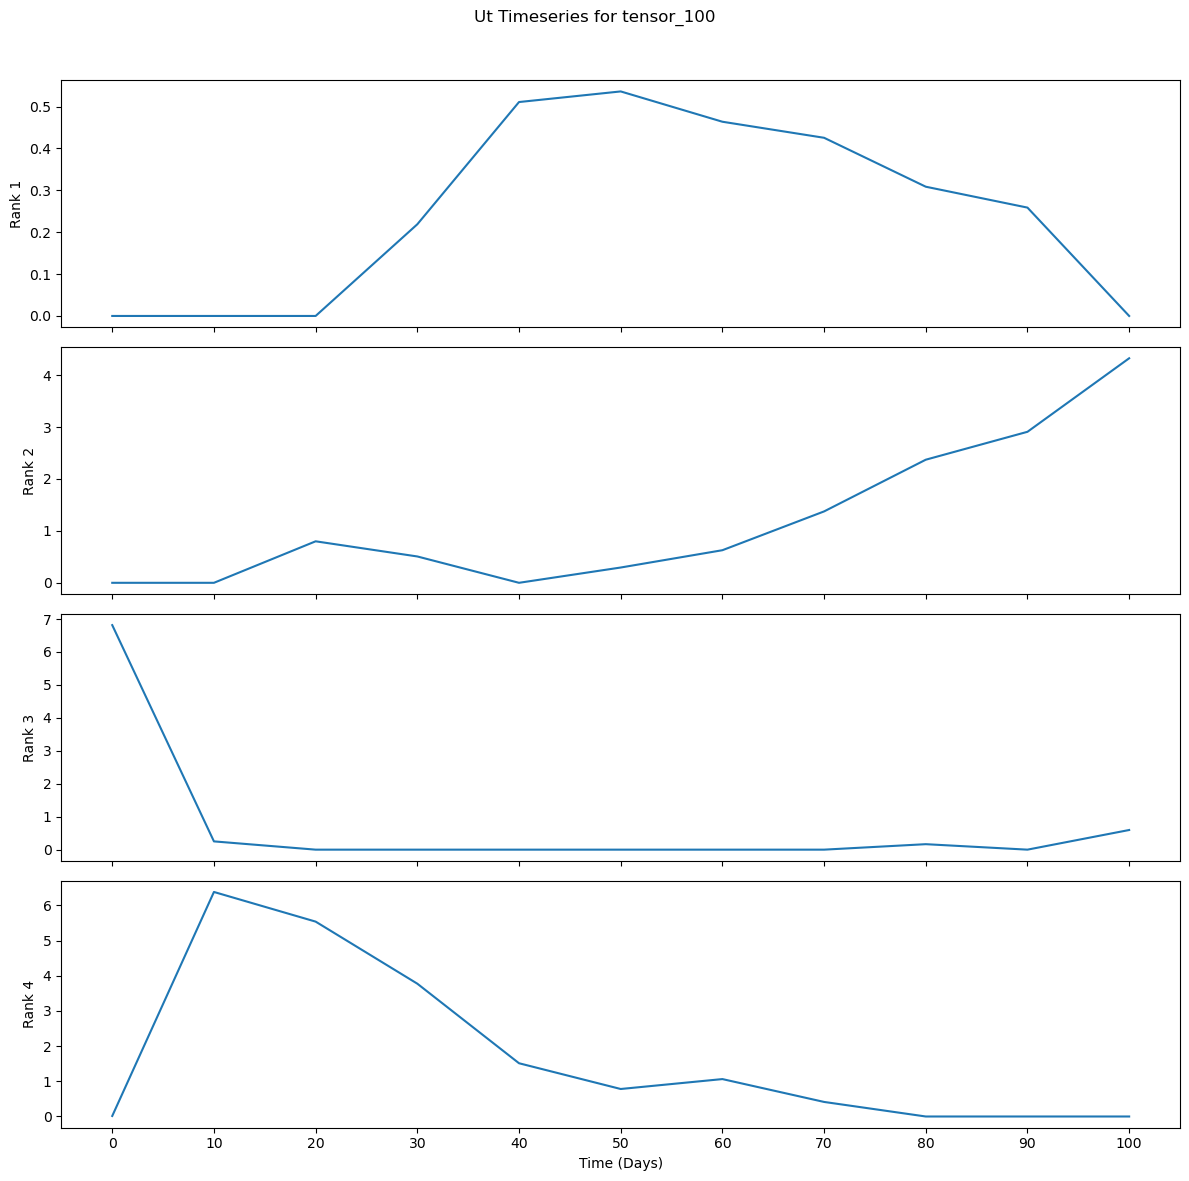

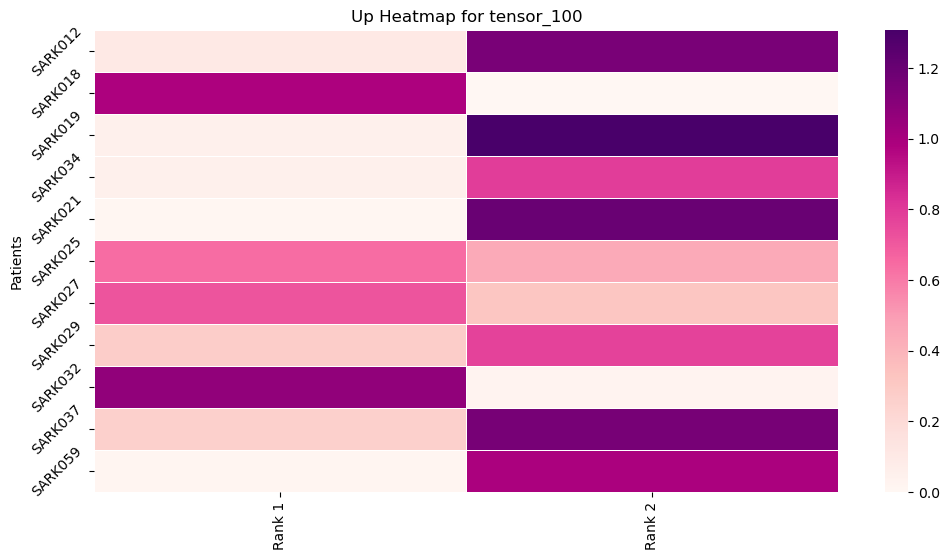

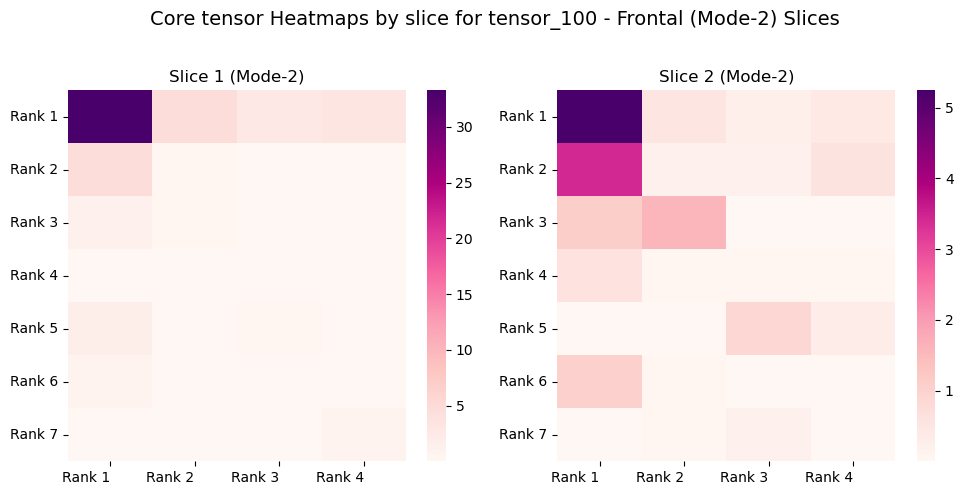

        Index        Weight      Fraction
0   (1, 1, 1)  3.327543e+01  9.055693e-01
1   (1, 1, 2)  5.242729e+00  2.247964e-02
2   (1, 2, 1)  4.724154e+00  1.825250e-02
8   (2, 1, 1)  4.635621e+00  1.757479e-02
9   (2, 1, 2)  3.436055e+00  9.655944e-03
6   (1, 4, 1)  3.321850e+00  9.024735e-03
4   (1, 3, 1)  2.806922e+00  6.443695e-03
32  (5, 1, 1)  1.749295e+00  2.502652e-03
19  (3, 2, 2)  1.569708e+00  2.015172e-03
16  (3, 1, 1)  1.338634e+00  1.465540e-03
17  (3, 1, 2)  1.094830e+00  9.803191e-04
41  (6, 1, 2)  1.007167e+00  8.296162e-04
37  (5, 3, 2)  9.006599e-01  6.634314e-04
40  (6, 1, 1)  8.666821e-01  6.143192e-04
54  (7, 4, 1)  7.693909e-01  4.841372e-04
25  (4, 1, 2)  5.965692e-01  2.910691e-04
15  (2, 4, 2)  5.795931e-01  2.747393e-04
3   (1, 2, 2)  5.182962e-01  2.197002e-04
7   (1, 4, 2)  4.158275e-01  1.414167e-04
10  (2, 2, 1)  4.068250e-01  1.353598e-04
39  (5, 4, 2)  3.244175e-01  8.607617e-05
18  (3, 2, 1)  3.243637e-01  8.604762e-05
36  (5, 3, 1)  2.677223e-01  5.861

In [88]:
i=1 #tensor_100
td_dic = tucker_results[tensor_names[i]]
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']
decomp_visualizations(td_dic,tensor_names[i], pat_list=pat_list)

##### tensor_200

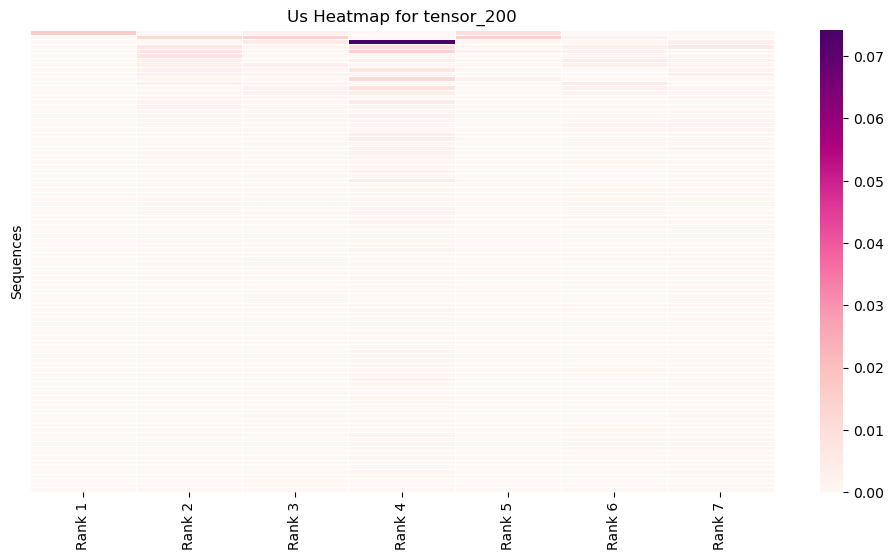

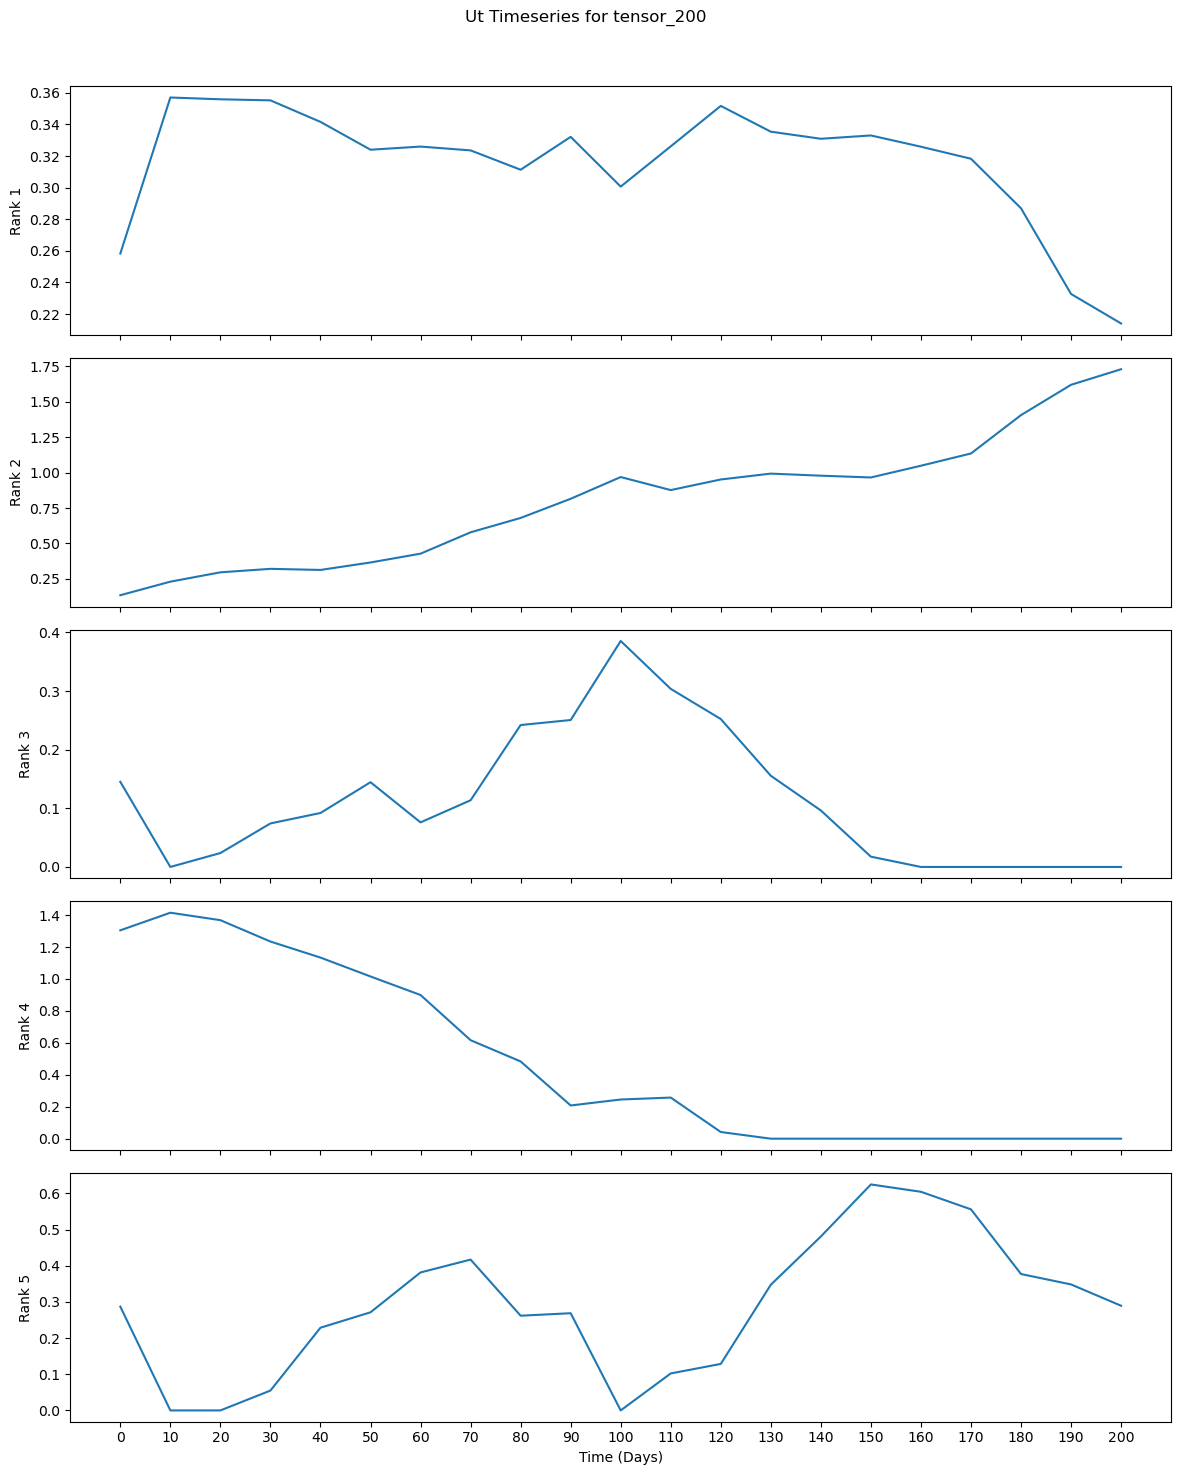

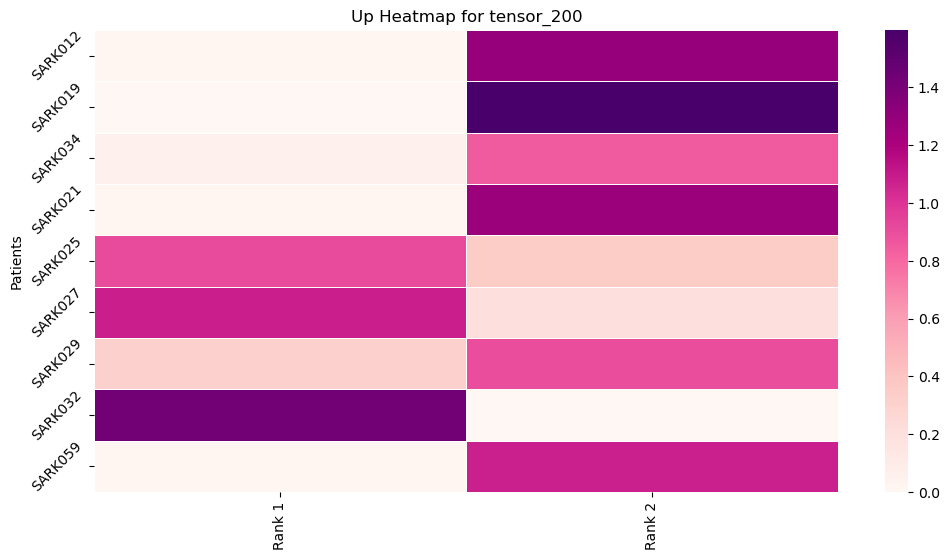

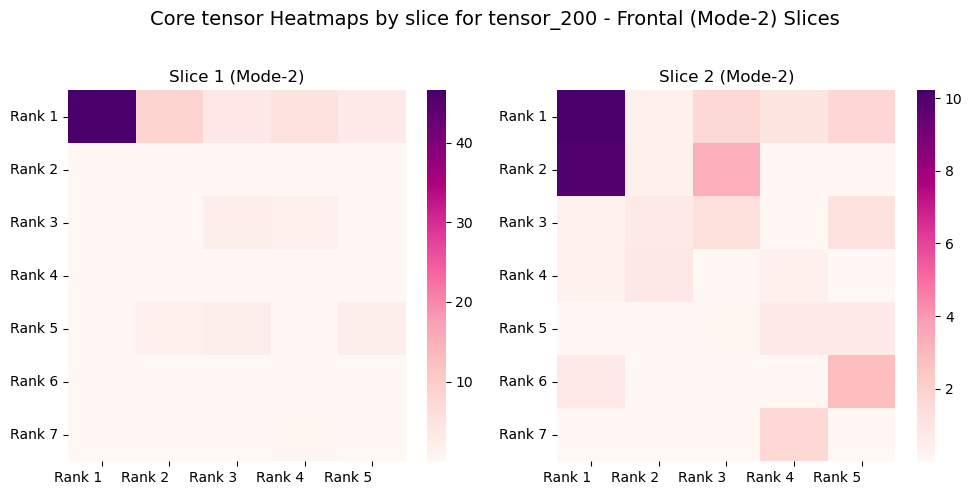

        Index        Weight      Fraction
0   (1, 1, 1)  4.657643e+01  8.482764e-01
1   (1, 1, 2)  1.021870e+01  4.083162e-02
11  (2, 1, 2)  9.997270e+00  3.908120e-02
2   (1, 2, 1)  8.533047e+00  2.847169e-02
6   (1, 4, 1)  5.111568e+00  1.021676e-02
4   (1, 3, 1)  4.084486e+00  6.523489e-03
15  (2, 3, 2)  3.298235e+00  4.253712e-03
8   (1, 5, 1)  3.081213e+00  3.712346e-03
59  (6, 5, 2)  2.771203e+00  3.002906e-03
48  (5, 5, 1)  2.513251e+00  2.469885e-03
24  (3, 3, 1)  2.478075e+00  2.401230e-03
44  (5, 3, 1)  2.262987e+00  2.002485e-03
42  (5, 2, 1)  1.953406e+00  1.492072e-03
9   (1, 5, 2)  1.750109e+00  1.197665e-03
67  (7, 4, 2)  1.642565e+00  1.054994e-03
5   (1, 3, 2)  1.612825e+00  1.017137e-03
26  (3, 4, 1)  1.551461e+00  9.412105e-04
25  (3, 3, 2)  1.331600e+00  6.933499e-04
29  (3, 5, 2)  1.192511e+00  5.560707e-04
7   (1, 4, 2)  1.020992e+00  4.076145e-04
33  (4, 2, 2)  8.682091e-01  2.947499e-04
51  (6, 1, 2)  7.786648e-01  2.370861e-04
49  (5, 5, 2)  7.393921e-01  2.137

In [89]:
i=2 #tensor_200
td_dic = tucker_results[tensor_names[i]]
pat_list = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']
decomp_visualizations(td_dic,tensor_names[i], pat_list=pat_list)

##### tensor_300

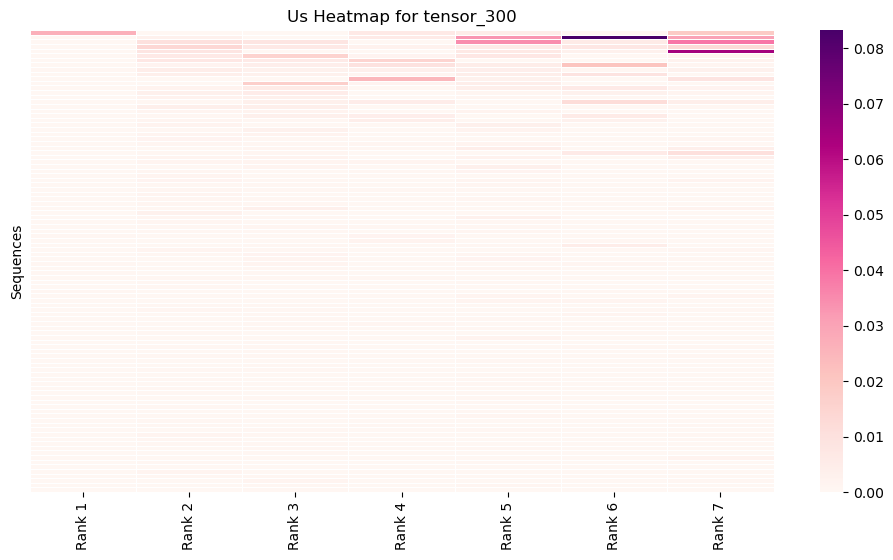

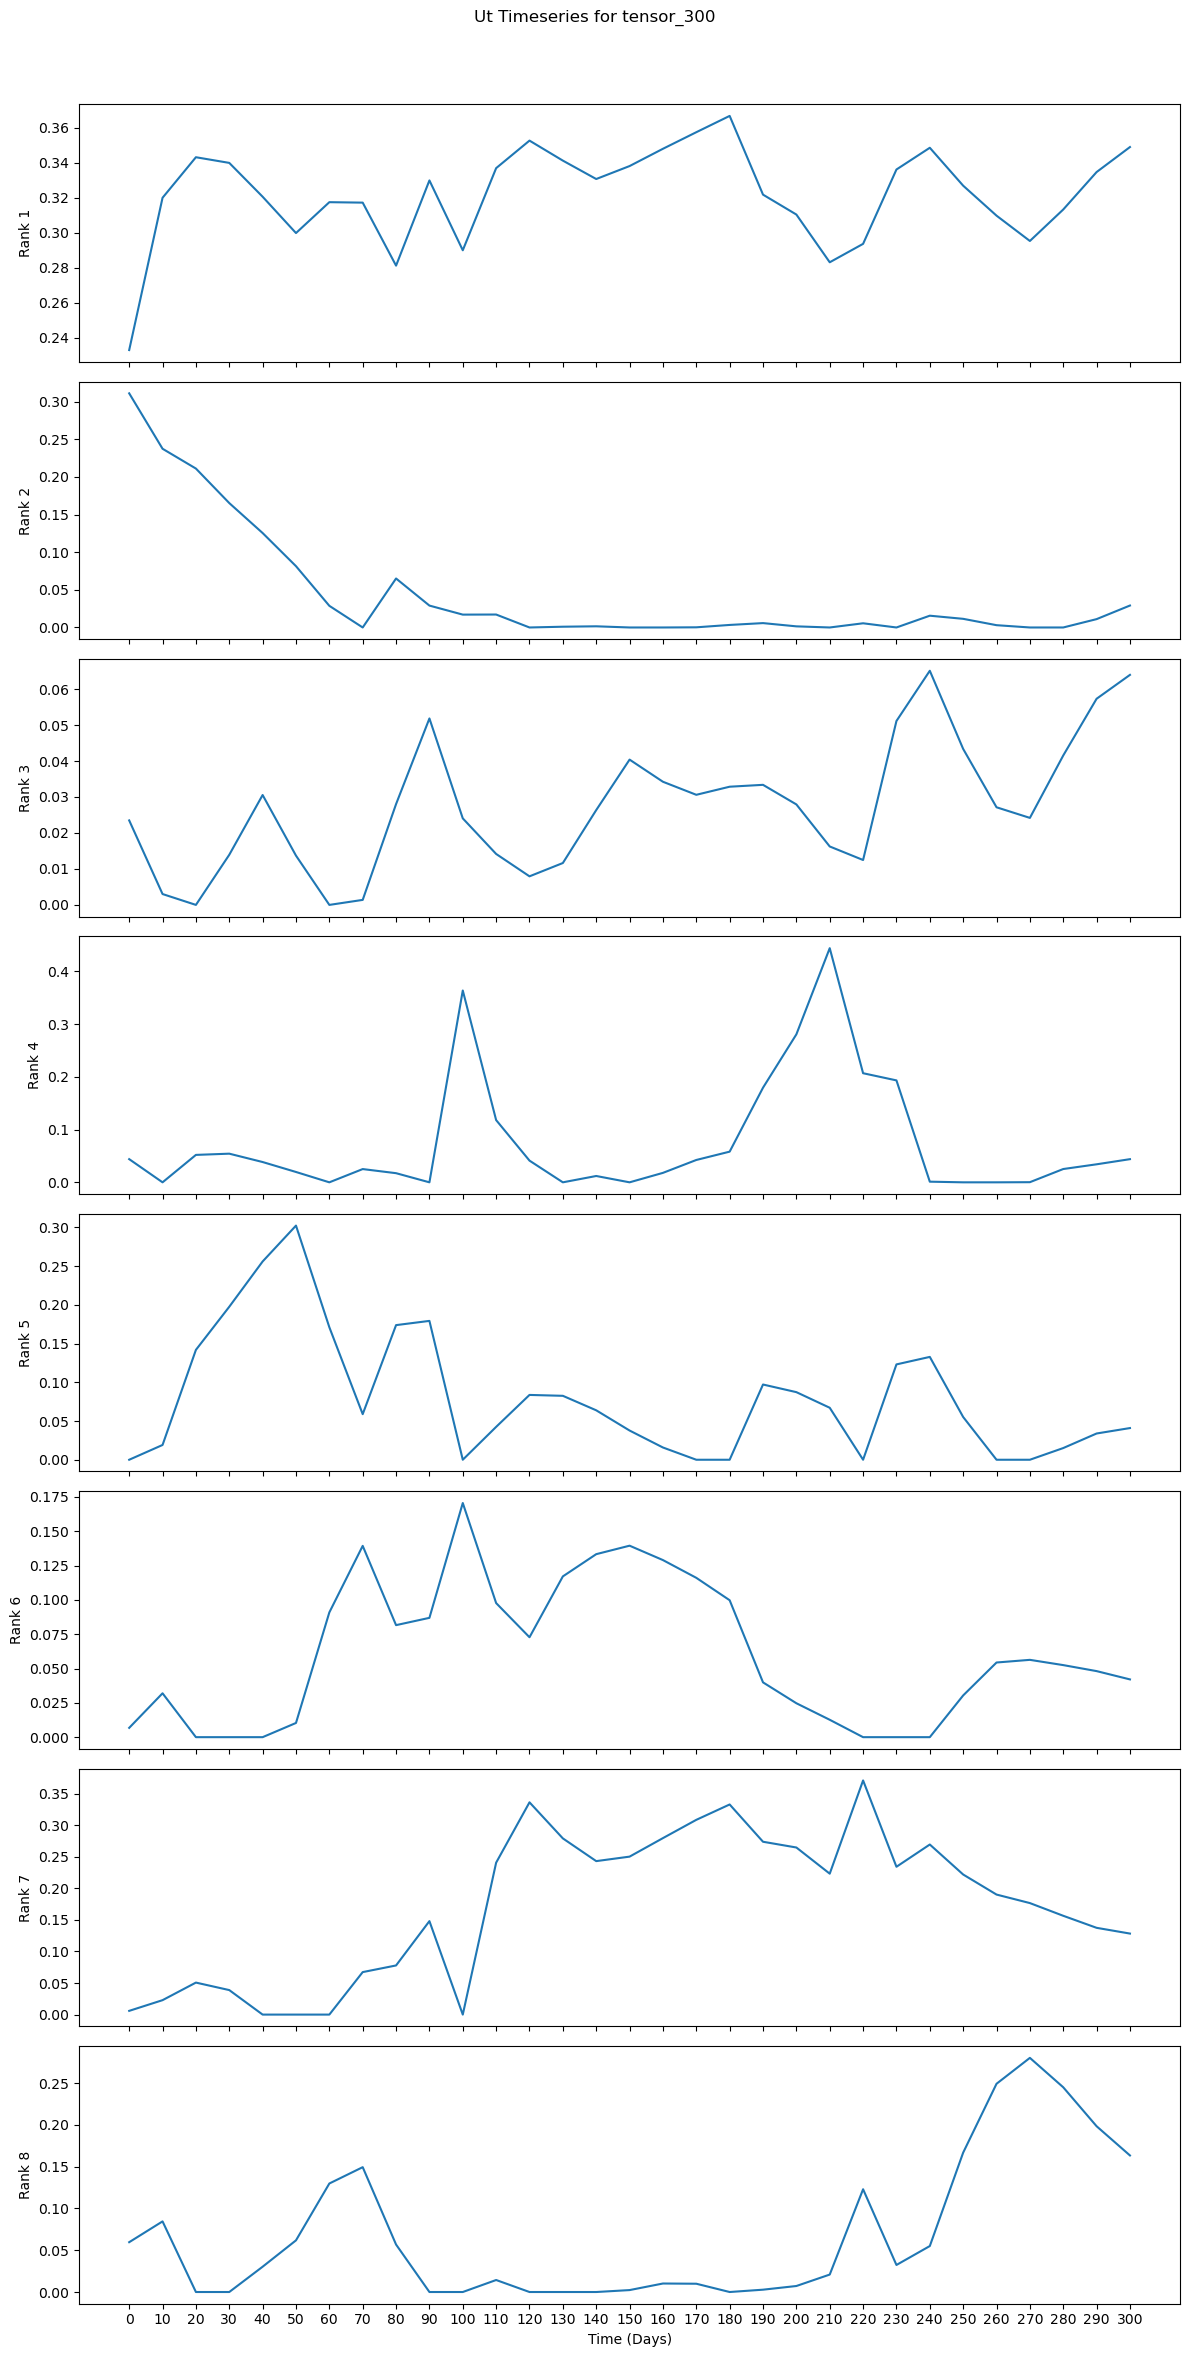

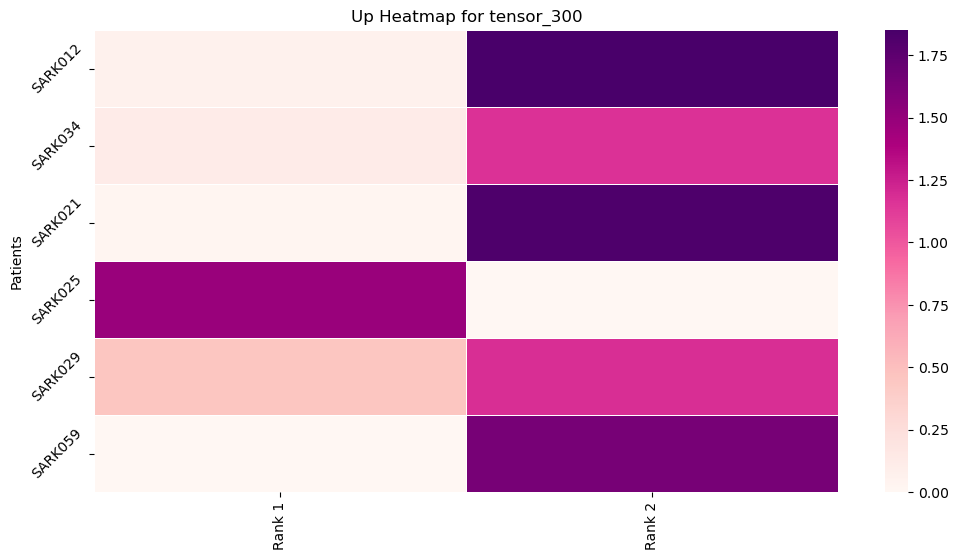

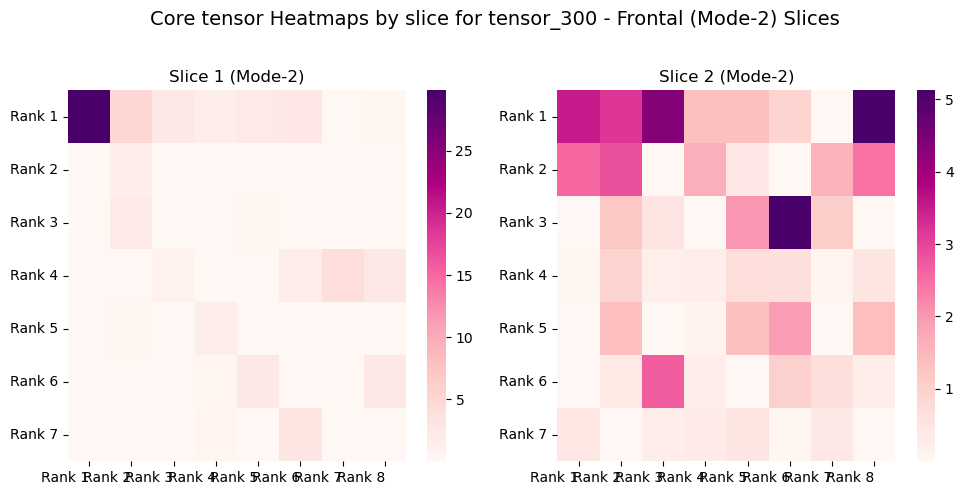

         Index        Weight      Fraction
0    (1, 1, 1)  2.987531e+01  7.773188e-01
15   (1, 8, 2)  5.122584e+00  2.285349e-02
43   (3, 6, 2)  5.106154e+00  2.270712e-02
2    (1, 2, 1)  4.962535e+00  2.144774e-02
5    (1, 3, 2)  4.358783e+00  1.654645e-02
60   (4, 7, 1)  4.012351e+00  1.402078e-02
1    (1, 1, 2)  3.519171e+00  1.078587e-02
3    (1, 2, 2)  3.180874e+00  8.811853e-03
106  (7, 6, 1)  2.938241e+00  7.518812e-03
19   (2, 2, 2)  2.875801e+00  7.202644e-03
85   (6, 3, 2)  2.704121e+00  6.368344e-03
17   (2, 1, 2)  2.590315e+00  5.843586e-03
10   (1, 6, 1)  2.575314e+00  5.776102e-03
4    (1, 3, 1)  2.540731e+00  5.622012e-03
62   (4, 8, 1)  2.531395e+00  5.580771e-03
94   (6, 8, 1)  2.518424e+00  5.523726e-03
88   (6, 5, 1)  2.496852e+00  5.429500e-03
31   (2, 8, 2)  2.457743e+00  5.260744e-03
8    (1, 5, 1)  2.251804e+00  4.416064e-03
41   (3, 5, 2)  2.025236e+00  3.572117e-03
34   (3, 2, 1)  1.967134e+00  3.370095e-03
75   (5, 6, 2)  1.930091e+00  3.244368e-03
58   (4, 6,

In [90]:
i=3 #tensor_300
td_dic = tucker_results[tensor_names[i]]
pat_list = ['SARK012', 'SARK034', 'SARK021', 'SARK025', 
            'SARK029', 'SARK059']
decomp_visualizations(td_dic,tensor_names[i], pat_list=pat_list)

### Clustering

### Classification